In [1]:
import pandas as pd
import DataLoading
import NN_classes
import NN_evaluation
import torch
import matplotlib.pyplot as plt
import  numpy as np

In [2]:
sc = "sc01"
period = "2030"
folder = "../Data/3-bus_AC_12w_ext_o_dummy_LCOE/"
folder = "../Data/9n_AC_12w_ext_o_dummy_LCOE/"
all_executions = DataLoading.list_executions(folder=folder,per = period,sc=sc)
te_s = 0.3
val_s = 0.4

In [3]:
dfs_in, dfs_out, dfs_inter = DataLoading.load_data_ext_out(folder, all_executions, period, sc, ["PowerFlow"])
dfs_inter_j = DataLoading.join_frames_inter_layer(dfs_inter)
dfs_inter_j = DataLoading.trim_columns_to_common(dfs_inter_j)
# Convert to pytorch tensors
ts_in, ts_out, ts_inter = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, dfs_inter_j, all_executions, te_s, val_s)
d_ft_in, d_ft_out, d_ft_inter,maxs = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, ts_inter, all_executions)

input_size = dfs_in["Network_Existing_Generation_Full"].shape[1]
inter_size = dfs_inter_j["Network_Existing_Generation_Full"].shape[1]

input_f_sc01_Network_Existing_Generation_Full_2030.csv
24
input_f_sc01_Network_Line_In_Node_1_Node_6_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_2_Node_3_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_2_Node_6_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_3_Node_4_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_3_Node_6_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_4_Node_5_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_4_Node_6_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_4_Node_9_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_6_Node_7_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_6_Node_8_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_7_Node_8_cac1_2030.csv
24
input_f_sc01_Network_Line_In_Node_8_Node_9_cac1_2030.csv
24


In [ ]:
def calculate_lb_from_dfs_out(dfs_out,execution): 
    return (dfs_out["Network_Existing_Generation_Full"].sum(axis=1) - dfs_out[execution].sum(axis=1))

def calculate_lb_from_ts_out(ts_out,ex):
    b= "Network_Existing_Generation_Full"
    all_ts_out_ex = torch.concat((ts_out["train"][ex],ts_out["test"][ex],ts_out["val"][ex]))
    all_ts_out_benchmark = torch.concat((ts_out["train"][b],ts_out["test"][b],ts_out["val"][b]))
    return all_ts_out_benchmark-all_ts_out_ex
    

def find_xthbest_model_params_from_df(df_losses,loss_to_sort,xth_best=1):
    return df_losses.sort_values(by =loss_to_sort)[xth_best-1:xth_best]

def extract_model_params_from_row(row):
    model_type = row.Model_type.item()
    model_type = tuple(map(int, model_type.replace("(","").replace(")","").split(', ')))
    dor = row.Dor.item()
    lr = row.Lr.item()
    nb_e = row.Epochs.item()

    relu_out = row.Relu_out.item()
    np =row.Np.item()
    bs = row.Batch_size.item()
    alpha = row.alpha.item()
    MAE = row.MAE.item()
    
    return {"Model_type": model_type,"nb_e":nb_e,"lr":lr,"dor":dor,"np":np,"ro":relu_out,"bs":bs,"alpha":alpha,"MAE":MAE}
    

def create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run = True):
    #First, extract params from row
    
    model_type = row.Model_type.item()
    model_type = tuple(map(int, model_type.replace("(","").replace(")","").split(', ')))
    dor = row.Dor.item()
    lr = row.Lr.item()
    nb_e = row.Epochs.item()

    relu_out = row.Relu_out.item()
    np =row.Np.item()
    bs = row.Batch_size.item()
    alpha = row.alpha.item()
    MAE = row.MAE.item()
    
    if str(alpha) == "0.0": 
        alpha = "0"

    if row.Min_val.item(): 
        mt = "min_val"
    else: 
        mt = "all_epochs"
    
    #Then create model of given type
    m = NN_classes.create_model(model_type,input_size, dropout_ratio= dor,relu_out =relu_out,inter=True,inter_size=inter_size)
    
    #Finally, extract model state from dict
    
    #m_name = f"OE_{model_type}h_{nb_e}e_{lr}lr_{dor}dor_{np}np_{relu_out}_ro_{bs}bs"
    m_name = f"OE_{model_type}h_{nb_e}e_{lr}lr_{dor}dor_{np}np_{relu_out}ro_{bs}bs_{alpha}ill_{MAE}MAE"

    if cluster_run:
        #m_name = f"OE_{model_type}h_{nb_e}e_{lr}lr_{dor}dor_{np}np_{relu_out}_ro_{bs}bs"
        path = f"ResultsClusterRuns/trained_models/{hyperloop_name}/{mt}/model_{m_name}.pth"
    else:
        path = f"trained_models/{hyperloop_name}/{mt}/model_{m_name}.pth"

    m.load_state_dict(torch.load(path))
    m.eval()
    
    return m
def get_lb_est_and_actual(m,ex,dfs_in,dfs_out): 
    negf = all_executions[0]
    ex_in_e = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
    ex_in_negf = torch.nan_to_num(dfs_in[negf].to_numpy()/maxs["in"])

    prediction_e = m(ex_in_e.float())[0].detach().numpy()
    prediction_negf = m(ex_in_negf.float())[0].detach().numpy()

    lb_est = prediction_negf- prediction_e
    lb_actual = calculate_lb_from_dfs_out(dfs_out,ex).to_numpy()
    return lb_est.flatten(),lb_actual.flatten()

In [4]:
#Counting ocurences of negative and positive values for all execs: 
#hyperloop_name = "RTS24_AC_12w_dummy_0.3_v0.4_PF_sa_rand_0_40"
hyperloop_name ="3-bus_AC_12w_dummy_0.3_v0.4_PF_LCOE_0_10"
hyperloop_name ="9n_AC_12w_dummy_0.3_v0.4_PF_LCOE_0_13"
df_losses = pd.read_csv(f"ResultsClusterRuns/Loss_results_csv/{hyperloop_name}.csv",index_col=0)
#df_losses = pd.read_csv(f"Loss_results_csv/{hyperloop_name}.csv",index_col=0)

f = df_losses.alpha ==0.0

loss_to_sort = "Te_l_t_mse"

xth_best = 1
row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=True)


[48, 72, 18, 12]


AttributeError: Rectangle.set() got an unexpected keyword argument 'xlabels'

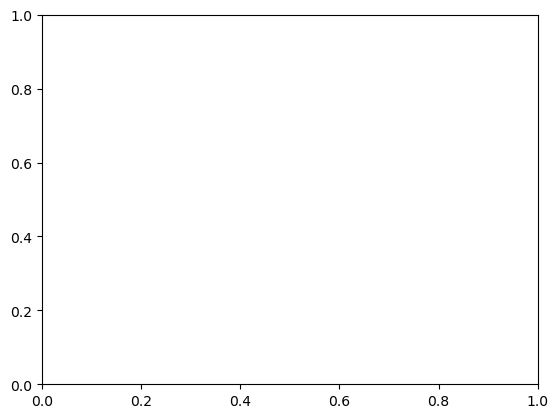

In [7]:
i=0
ex = all_executions[0]

all_counts = pd.DataFrame()
for ex in all_executions:
    lb_est,lb_actual = NN_evaluation.get_lb_est_and_actual(m,ex,dfs_in,dfs_out,all_executions,maxs)

    both_positive_count = np.sum((lb_est > 0) & (lb_actual > 0))
    both_negative_count = np.sum((lb_est < 0) & (lb_actual < 0))
    opposite_sign_count = np.sum((lb_est * lb_actual) < 0)
    BZ = np.sum((lb_est==0) & (lb_actual == 0))
    OZ = np.sum((lb_est * lb_actual) == 0)


    row_lb = pd.DataFrame({"exec":ex,"BP":both_positive_count, "BN":both_negative_count,"OS":opposite_sign_count,"OZ":OZ,"BZ":BZ,}, index = [i])
    all_counts = pd.concat([all_counts,row_lb],axis=0)
    i+=1
plt.bar(height = [both_positive_count,both_negative_count,opposite_sign_count],x=[0,1,2],xlabels =["both_positive","both_negative","Opposite sign"])

In [11]:
mpd = model_params_dict = extract_model_params_from_row(row)
keys = ["Model_type","nb_e","lr","dor","np","ro","bs","alpha","MAE"]
name = f"sign_counts_{mpd[keys[0]]}h_{mpd[keys[1]]}e_{mpd[keys[2]]}lr_{mpd[keys[3]]}dor_{mpd[keys[4]]}np_{mpd[keys[5]]}ro_{mpd[keys[6]]}bs_{mpd[keys[7]]}ill_{mpd[keys[8]]}MAE"
#all_counts.to_csv(f"LB_sign_counts/{name}.csv")

In [8]:
all_counts.sum()

exec    Network_Existing_Generation_FullNetwork_Line_I...
BP                                                   8944
BN                                                   3232
OS                                                  11132
OZ                                                   5084
BZ                                                   2184
dtype: object

In [13]:
np.sum((lb_est > 0) & (lb_actual > 0))

536

In [14]:
np.sum((lb_est > 0) & (lb_actual > 0))

536

In [41]:
(lb_est > 0) & (lb_actual > 0)
lb_est.flatten()

array([1.67787075e-05, 1.67414546e-05, 1.56611204e-05, ...,
       1.58406794e-04, 1.11535192e-05, 1.40964985e-05], dtype=float32)